# Analysis of clusters in sample S3

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")


/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


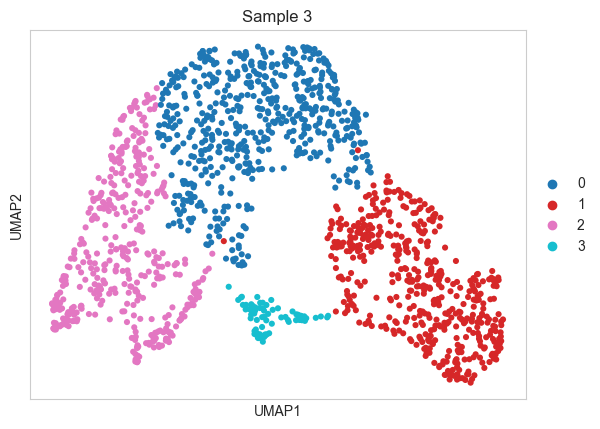

In [4]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[grou

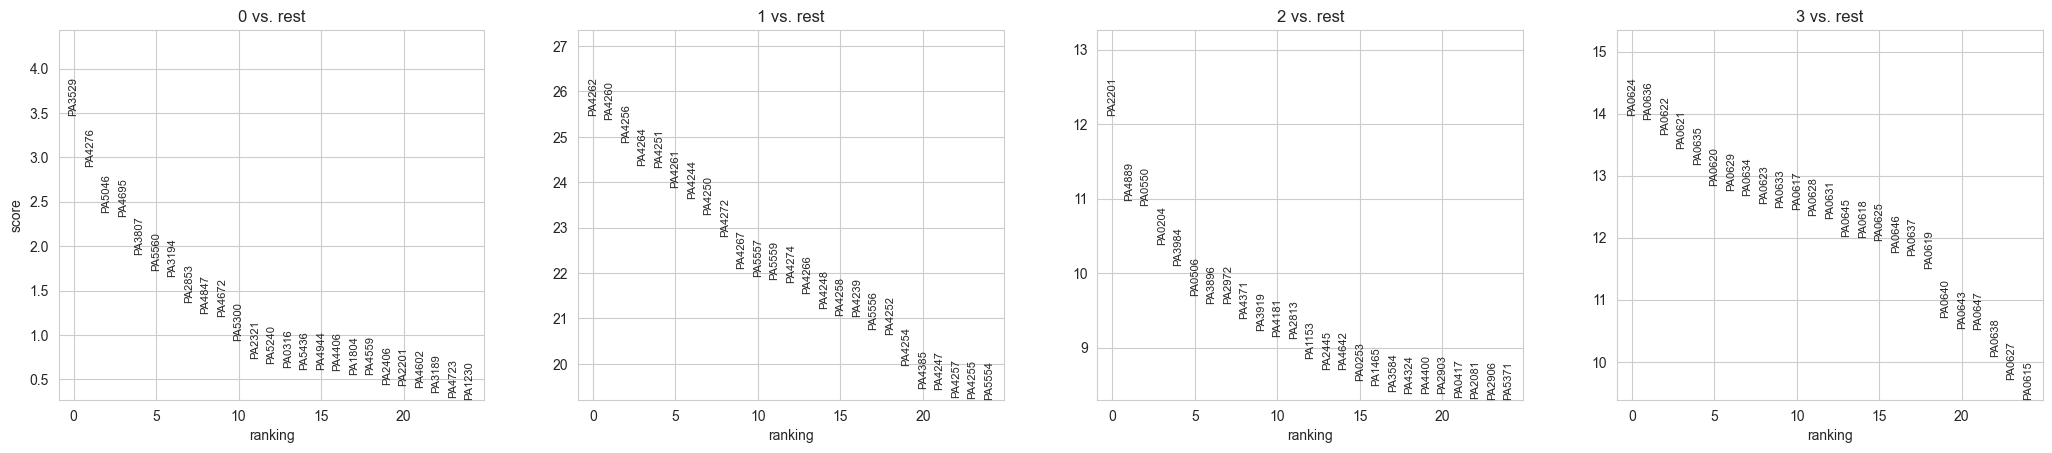

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [6]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB a

## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)

data_gen_noscale, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)


xmin = 1.2360679772046799

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [92]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [93]:
data_null_gen.var_names

Index(['PA0001', 'PA0002', 'PA0003', 'PA0004', 'PA0005', 'PA0006', 'PA0007',
       'PA0008', 'PA0009', 'PA0010',
       ...
       'PA5561', 'PA5562', 'PA5563', 'PA5564', 'PA5565', 'PA5566', 'PA5567',
       'PA5568', 'PA5569', 'PA5570'],
      dtype='object', name='PAO1_ID', length=5547)

In [94]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [95]:
data_null_gen.var

,var_counts,mean_counts
PAO1_ID,,
PA0001,0.849472,0.680699
PA0002,0.727811,0.512953
PA0003,1.205480,0.933938
PA0004,0.479405,0.420337
PA0005,0.142446,0.141839
...,...,...
PA5566,0.017893,0.015544
PA5567,0.176844,0.132124
PA5568,0.861607,0.712435


In [96]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

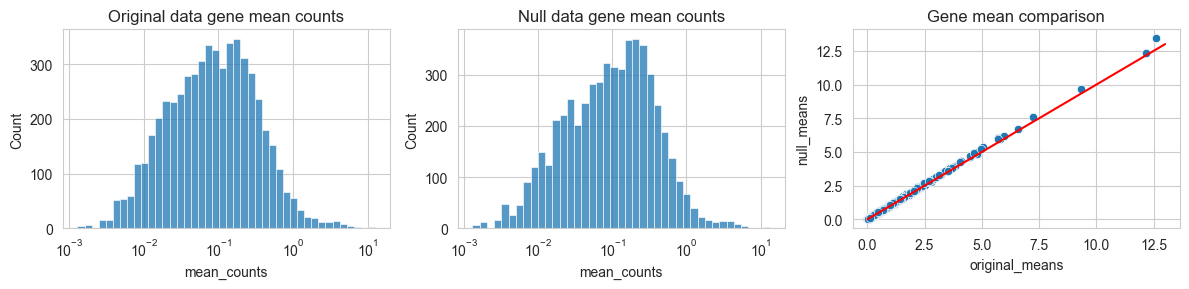

SignificanceResult(statistic=0.9968519579769592, pvalue=0.0)


In [97]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

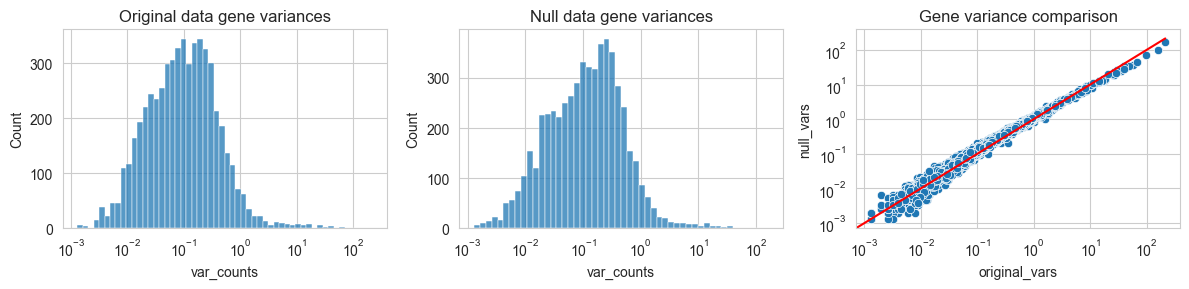

SignificanceResult(statistic=0.9949533936602659, pvalue=0.0)
[[1.         0.99481202]
 [0.99481202 1.        ]]


In [98]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

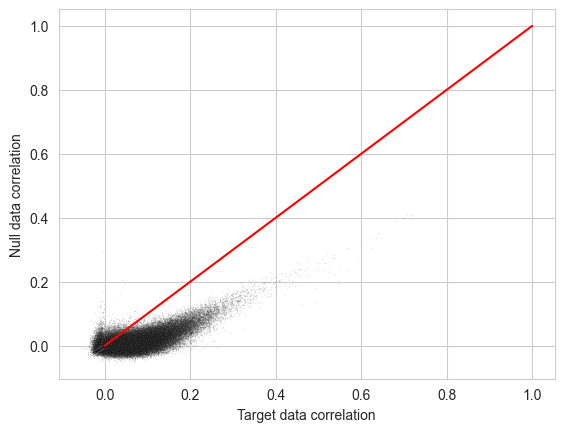

In [99]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [100]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [101]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


In [102]:
data_null_gen.var

,var_counts,mean_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,n_cells_by_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,
PA0001,0.849472,0.680699,False,6.047747,6.047747,-8.549166,2.624489,-8.609994,2.640219,0.019776,700,0.519210,54.663212,1051.0,6.958448,0.685112,0.343355
PA0002,0.727811,0.512953,False,4.371351,4.371351,-8.447749,2.489750,-9.723337,2.901568,0.052073,532,0.414064,65.544041,792.0,6.675823,0.342551,0.387763
PA0003,1.205480,0.933938,False,6.745422,6.745422,-8.550565,2.727940,-8.380817,2.667675,0.017167,853,0.659558,44.753886,1442.0,7.274480,0.856329,0.352152
PA0004,0.479405,0.420337,False,3.553378,3.553378,-8.353289,2.411146,NaN,NaN,NaN,497,0.350894,67.810881,649.0,6.476972,0.134589,0.403239
PA0005,0.142446,0.141839,False,0.911195,0.911195,-7.160612,1.692864,-6.661481,1.523562,0.010596,203,0.132640,86.852332,219.0,5.393628,-1.260152,0.580824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,0.017893,0.015544,False,0.112155,0.112155,-5.733038,0.501476,NaN,NaN,NaN,22,0.015424,98.575130,24.0,3.218876,-3.518637,0.466981
PA5567,0.176844,0.132124,False,0.795780,0.795780,-6.999835,1.599226,-7.371929,1.727851,0.073616,167,0.124096,89.183938,204.0,5.323010,-1.417110,0.588241
PA5568,0.861607,0.712435,False,6.262028,6.262028,-8.555145,2.644131,NaN,NaN,NaN,736,0.537916,52.331606,1100.0,7.003974,0.725979,0.334639


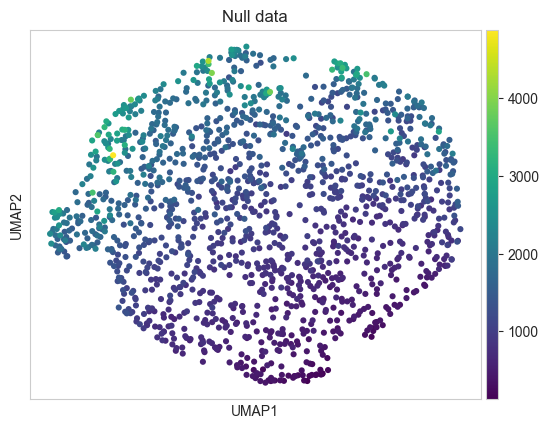

In [103]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [119]:
res2 = 0.01
twoclust = False
#345 vs. 456

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.01
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=13)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 4:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
0.1
0.15
Resolution for two clusters: 0.2


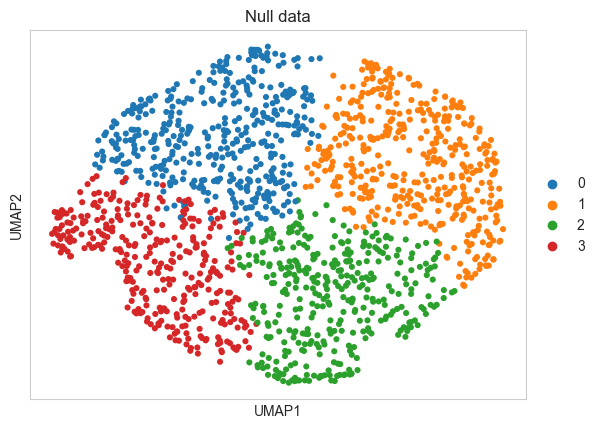

In [120]:
sc.pl.umap(data_null_gen, color="leiden", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [121]:
# data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [122]:
null_clust = ["0", "1", "2", "3"]

pval_null_gen = pd.DataFrame(index=data_null_gen.var.index)

for c in null_clust:
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == c]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != c]

    pval_null_gen[f"pval_null_{c}"] = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue

pval_null_gen["pval_null_mean"] = np.mean(np.array([pval_null_gen[f"pval_null_{c}"] for c in null_clust]), axis=0)

In [123]:
pval_null_gen

,pval_null_0,pval_null_1,pval_null_2,pval_null_3,pval_null_mean
PAO1_ID,,,,,
PA0001,3.196004e-06,9.442490e-01,2.030443e-10,1.512114e-01,2.738659e-01
PA0002,1.489821e-09,1.210147e-02,6.213934e-08,8.038617e-02,2.312193e-02
PA0003,8.601700e-07,8.895795e-01,2.138376e-07,8.646213e-01,4.385505e-01
PA0004,9.071027e-05,2.398981e-01,1.892515e-06,5.200611e-02,7.299920e-02
PA0005,9.436202e-02,2.156212e-01,9.713099e-02,2.160225e-01,1.557842e-01
...,...,...,...,...,...
PA5566,6.903930e-01,9.254580e-01,7.647858e-01,9.829487e-01,8.408964e-01
PA5567,2.089323e-01,9.539884e-01,4.540515e-01,5.161689e-01,5.332853e-01
PA5568,8.847400e-05,7.657727e-01,1.423862e-09,9.479321e-02,2.151636e-01


In [124]:
clusters = data_gene.obs["leiden_opt"].unique()
importlib.reload(cd)
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c0 in null_clust:
    print(f"Null cluster: {c0}")
    pval_null_gen_2 = pd.DataFrame({"pval_null": pval_null_gen[f"pval_null_{c0}"]})
    
    for c in clusters:
        X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
        X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
        p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
        DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen_2, FDR=fdr, correct=False, nlog=True)
        data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
        data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
        data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
        
        DEs_log_gen[(c0, c)] = DE_TU
        pvals_log_gen[(c0, c)] = pval_TU
        print(f"Cluster {c} - DE genes: {len(DE_TU)}; Minimum q value: {np.min(pval_TU['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.25703037120359956
Cluster 1 - DE genes: 92; Minimum q value: 0.015151515151515152
Cluster 2 - DE genes: 96; Minimum q value: 0.013888888888888888
Cluster 3 - DE genes: 21; Minimum q value: 0.047619047619047616
Cluster 0 - DE genes: 0; Minimum q value: 0.10936591041303083
Cluster 1 - DE genes: 67; Minimum q value: 0.017241379310344827
Cluster 2 - DE genes: 5143; Minimum q value: 0.04184277261200338
Cluster 3 - DE genes: 0; Minimum q value: 1.0
Cluster 0 - DE genes: 0; Minimum q value: 0.3952130764740222
Cluster 1 - DE genes: 48; Minimum q value: 0.020833333333333332
Cluster 2 - DE genes: 43; Minimum q value: 0.030303030303030304
Cluster 3 - DE genes: 0; Minimum q value: 0.16666666666666666
Cluster 0 - DE genes: 0; Minimum q value: 0.1741160773849233
Cluster 1 - DE genes: 108; Minimum q value: 0.011764705882352941
Cluster 2 - DE genes: 5267; Minimum q value: 0.00847457627118644
Cluster 3 - DE genes: 0; Minimum q value: 1.0


In [125]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c0 in null_clust:
    print(f"Null cluster: {c0}")
    pval_null_gen_2 = pd.DataFrame({"pval_null": pval_null_gen[f"pval_null_{c0}"]})
    
    for c in clusters:
        X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
        X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
        p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
        DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen_2, FDR=fdr, correct=False, nlog=False)
        data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
        data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
        data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
        
        DEs_gen[(c0, c)] = DE_TU
        pvals_gen[(c0, c)] = pval_TU
        print(f"Cluster {c} - DE genes: {len(DE_TU)}; Minimum q value: {np.min(pval_TU['q'])}")

Null cluster: 0
Cluster 0 - DE genes: 0; Minimum q value: 0.058212058212058215
Cluster 1 - DE genes: 0; Minimum q value: 0.868122270742358
Cluster 2 - DE genes: 3641; Minimum q value: 0.03149976492712741
Cluster 3 - DE genes: 0; Minimum q value: 1.0
Null cluster: 1
Cluster 0 - DE genes: 2921; Minimum q value: 0.02394526795895097
Cluster 1 - DE genes: 0; Minimum q value: 0.3006872852233677
Cluster 2 - DE genes: 5092; Minimum q value: 0.018065268065268064
Cluster 3 - DE genes: 0; Minimum q value: 1.0
Null cluster: 2
Cluster 0 - DE genes: 0; Minimum q value: 0.07109557109557109
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 3242; Minimum q value: 0.03549060542797495
Cluster 3 - DE genes: 0; Minimum q value: 1.0
Null cluster: 3
Cluster 0 - DE genes: 1993; Minimum q value: 0.03513281919451585
Cluster 1 - DE genes: 0; Minimum q value: 0.25
Cluster 2 - DE genes: 5220; Minimum q value: 0.009174311926605505
Cluster 3 - DE genes: 0; Minimum q value: 1.0


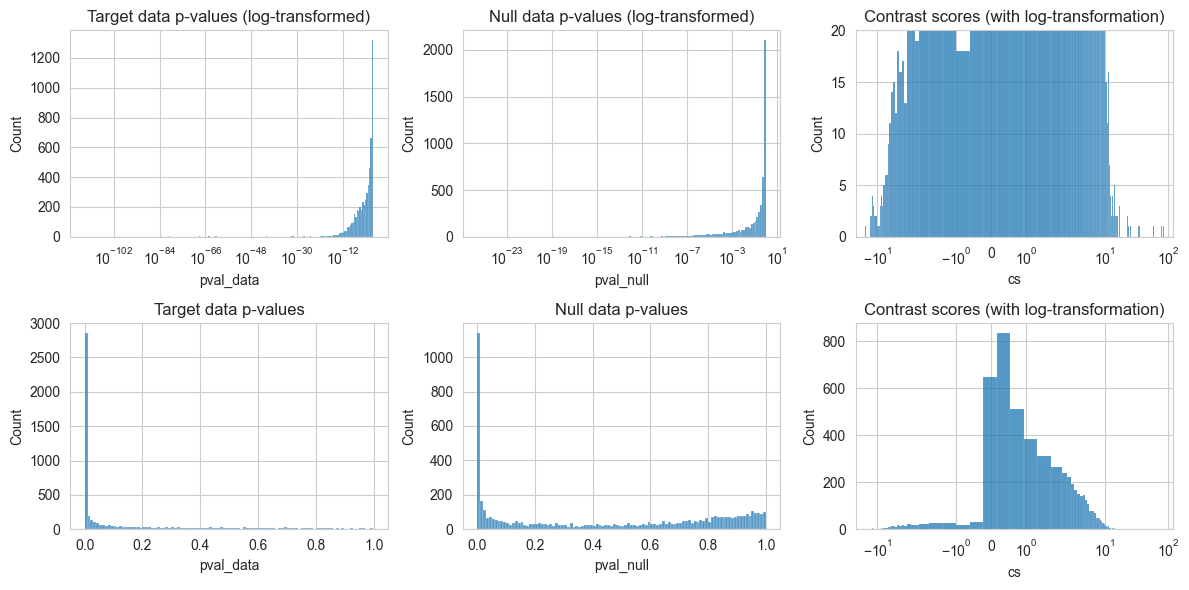

In [126]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[("0", c)], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[("0", c)], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[("0", c)], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog",
            ylim=(0, 20)
            )

sns.histplot(pvals_gen[("0", c)], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[("0", c)], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[("0", c)], x="cs", ax=ax[1,2])
ax[1,2].set_title("Contrast scores (with log-transformation)")
ax[1,2].set(xscale="symlog",)


plt.tight_layout()
plt.show()

In [127]:
for c0 in null_clust:
    for c in clusters:
        pvals_log_gen[(c0, c)]["cluster_null"] = c0
        pvals_log_gen[(c0, c)]["cluster"] = c
        
all_pvals_log = pd.concat(pvals_log_gen.values())
all_pvals_log

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q,cluster_null,cluster
PAO1_ID,,,,,,,,
PA4255,5.606549e-14,4.769429e-02,13.251304,1.321534,11.929771,0.25703,0,0
PA4261,6.799844e-11,2.104764e-02,10.167501,1.676797,8.490705,0.25703,0,0
PA3010,3.553747e-11,7.687614e-03,10.449313,2.114208,8.335105,0.25703,0,0
PA1271,1.972031e-12,3.930898e-04,11.705086,3.405508,8.299578,0.25703,0,0
PA0636,3.708294e-09,5.463875e-01,8.430826,0.262499,8.168327,0.25703,0,0
...,...,...,...,...,...,...,...,...
PA4267,4.433846e-01,1.365362e-73,0.353219,72.864752,-72.511533,1.00000,3,3
PA4261,1.188936e-01,1.638130e-74,0.924842,73.785652,-72.860810,1.00000,3,3
PA4262,4.799592e-01,9.421279e-80,0.318796,79.025890,-78.707094,1.00000,3,3


In [144]:
all_pvals_log[all_pvals_log["cluster"] == "0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q,cluster_null,cluster,pval_data_log,pval_null_log
PAO1_ID,,,,,,,,,,
PA4255,5.606549e-14,4.769429e-02,13.251304,1.321534,11.929771,0.25703,0,0,-13.251304,-1.321534
PA4261,6.799844e-11,2.104764e-02,10.167501,1.676797,8.490705,0.25703,0,0,-10.167501,-1.676797
PA3010,3.553747e-11,7.687614e-03,10.449313,2.114208,8.335105,0.25703,0,0,-10.449313,-2.114208
PA1271,1.972031e-12,3.930898e-04,11.705086,3.405508,8.299578,0.25703,0,0,-11.705086,-3.405508
PA0636,3.708294e-09,5.463875e-01,8.430826,0.262499,8.168327,0.25703,0,0,-8.430826,-0.262499
...,...,...,...,...,...,...,...,...,...,...
PA4264,2.125111e-02,7.080088e-71,1.672618,70.149961,-68.477343,1.00000,3,0,-1.672618,-70.149961
PA4267,8.903143e-03,1.365362e-73,2.050457,72.864752,-70.814295,1.00000,3,0,-2.050457,-72.864752
PA4262,2.901693e-06,9.421279e-80,5.537349,79.025890,-73.488542,1.00000,3,0,-5.537349,-79.025890


In [128]:
all_pvals_log_long = pd.wide_to_long(all_pvals_log.reset_index()[["PAO1_ID", "cluster_null", "cluster", "pval_data", "pval_null"]], stubnames="pval", i=["PAO1_ID", "cluster_null", "cluster"], j="kind", sep="_", suffix="(!?null|data)").reset_index()
all_pvals_log_long["log_pval"] = np.log10(all_pvals_log_long["pval"])
all_pvals_log_long

,PAO1_ID,cluster_null,cluster,kind,pval,log_pval
0,PA4255,0,0,data,5.606549e-14,-13.251304
1,PA4255,0,0,null,4.769429e-02,-1.321534
2,PA4261,0,0,data,6.799844e-11,-10.167501
3,PA4261,0,0,null,2.104764e-02,-1.676797
4,PA3010,0,0,data,3.553747e-11,-10.449313
...,...,...,...,...,...,...
177499,PA4262,3,3,null,9.421279e-80,-79.025890
177500,PA4260,3,3,data,7.310230e-01,-0.136069
177501,PA4260,3,3,null,1.789055e-82,-81.747376
177502,PA4256,3,3,data,6.801165e-01,-0.167417


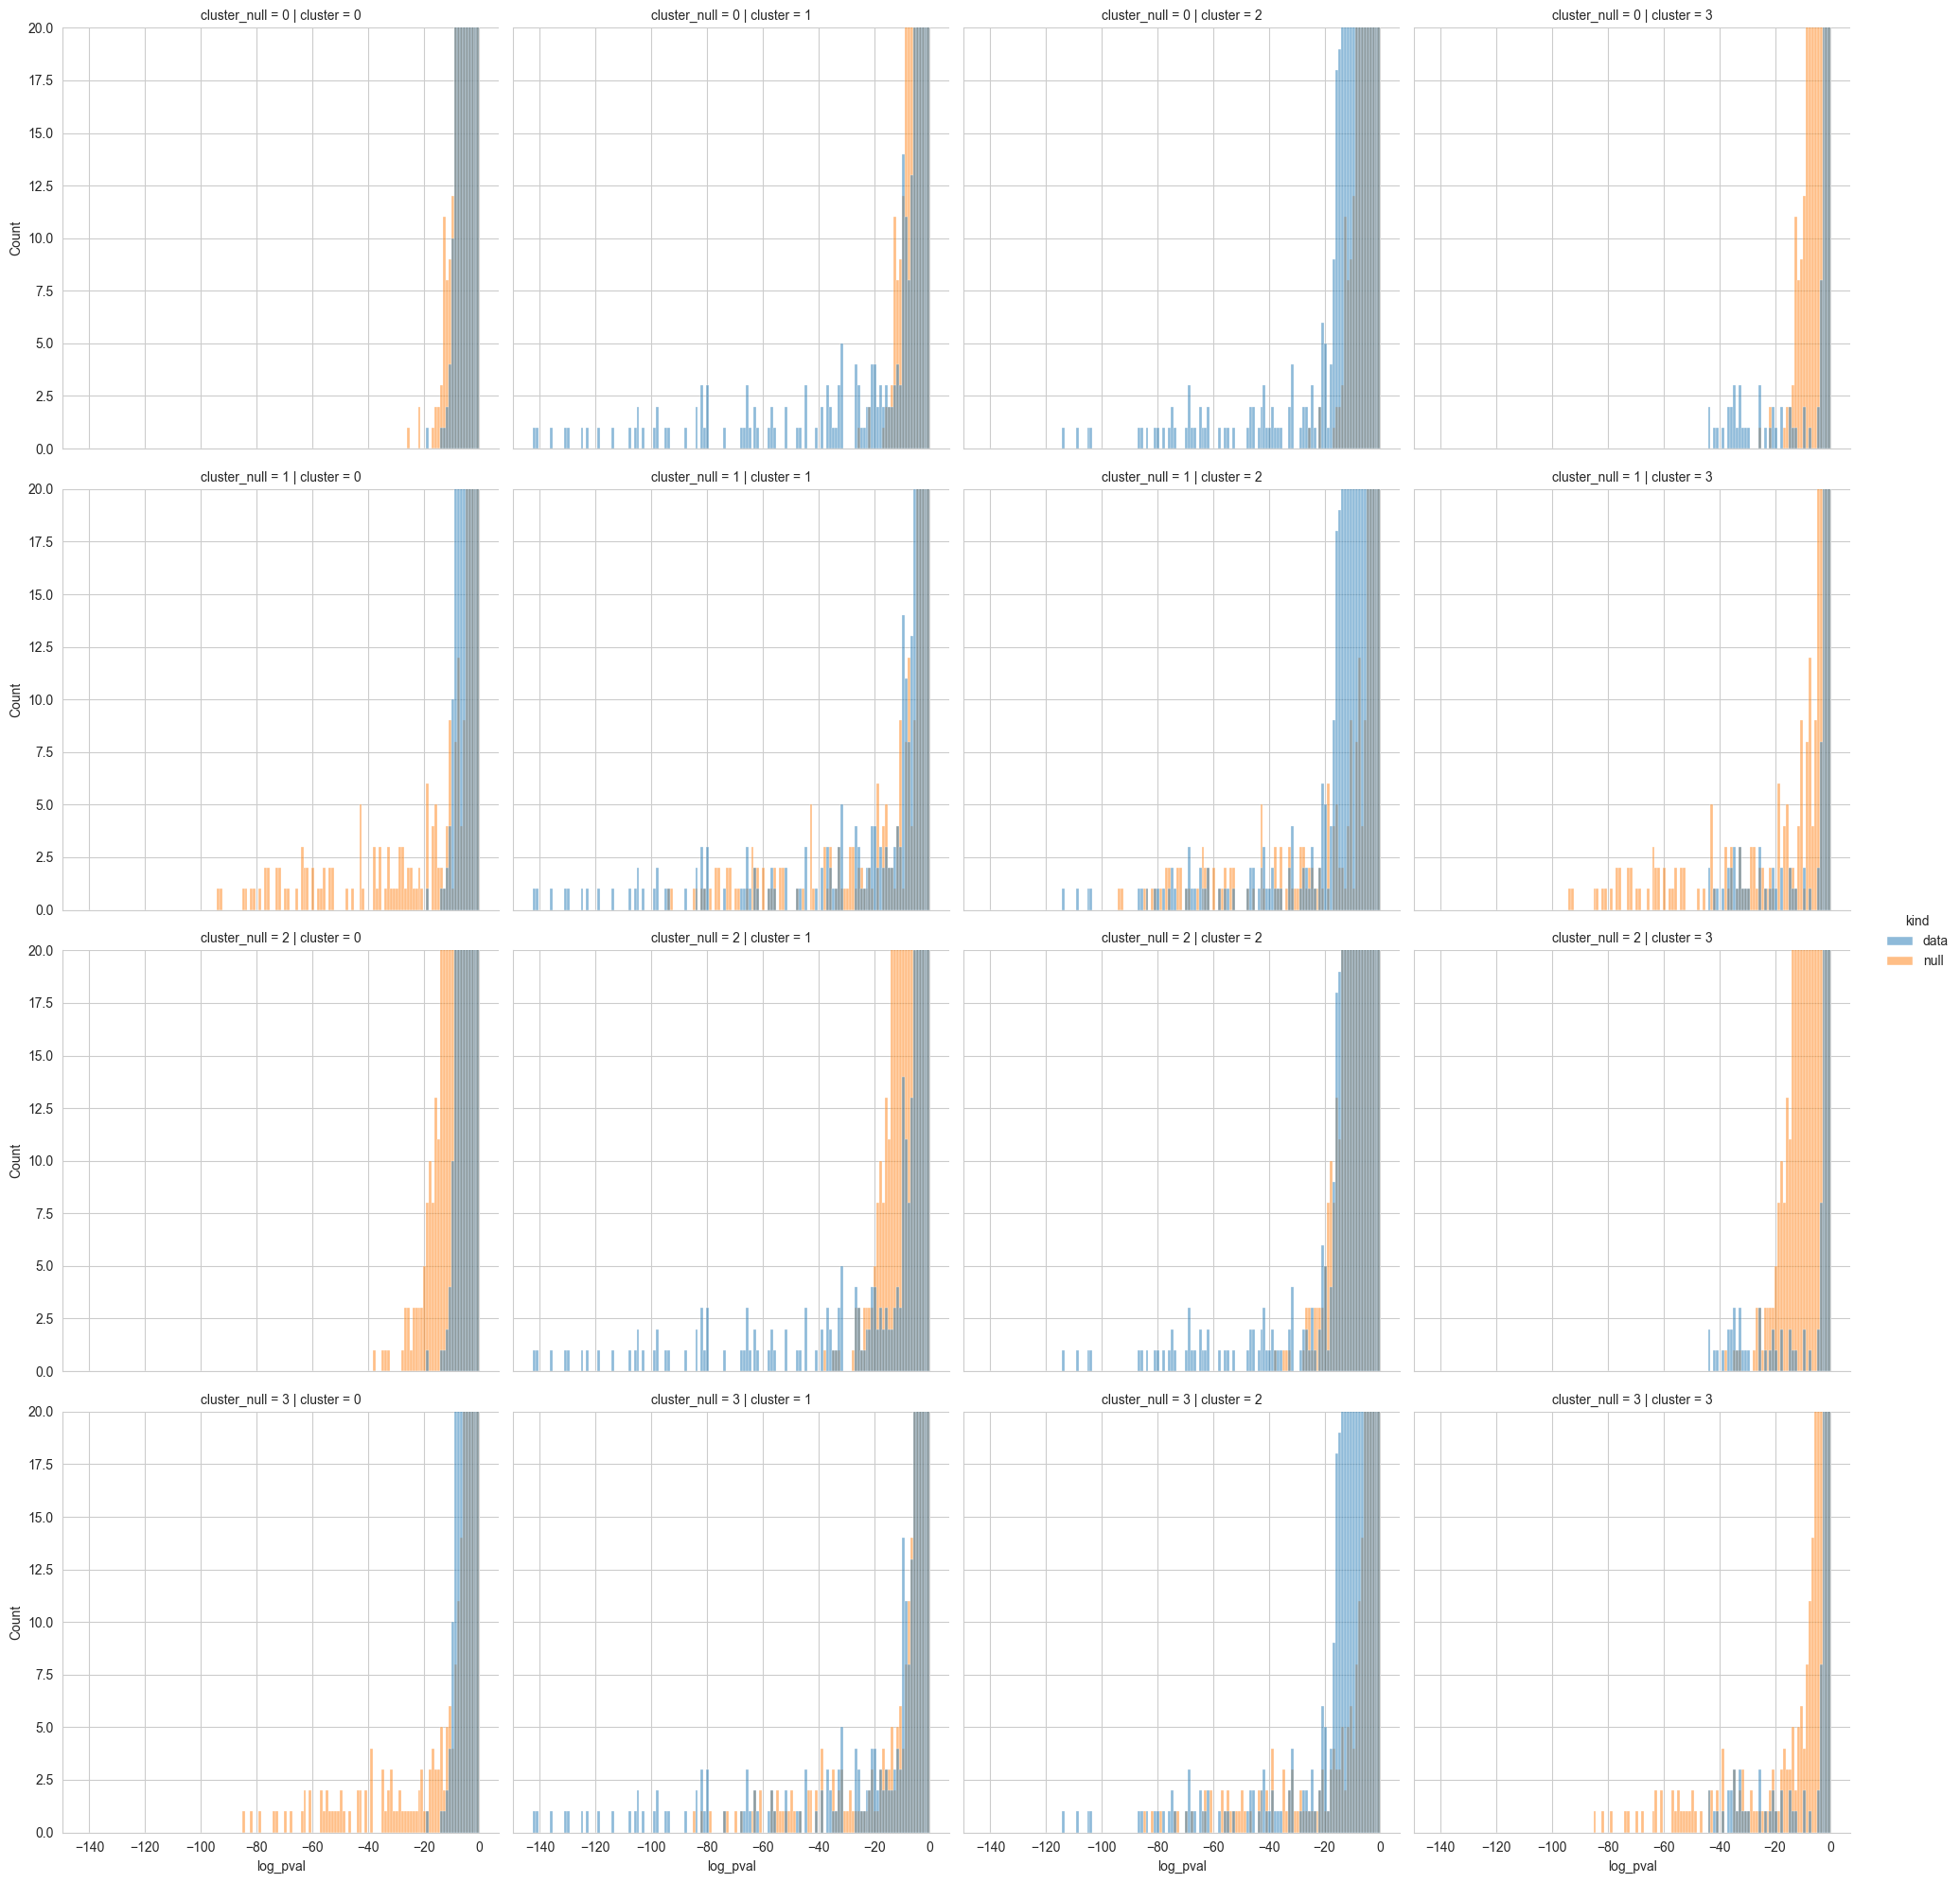

In [129]:
sns.displot(all_pvals_log_long, row="cluster_null", col="cluster", x="log_pval", hue="kind", kind="hist", binwidth=1)
plt.ylim((0,20))
plt.show()

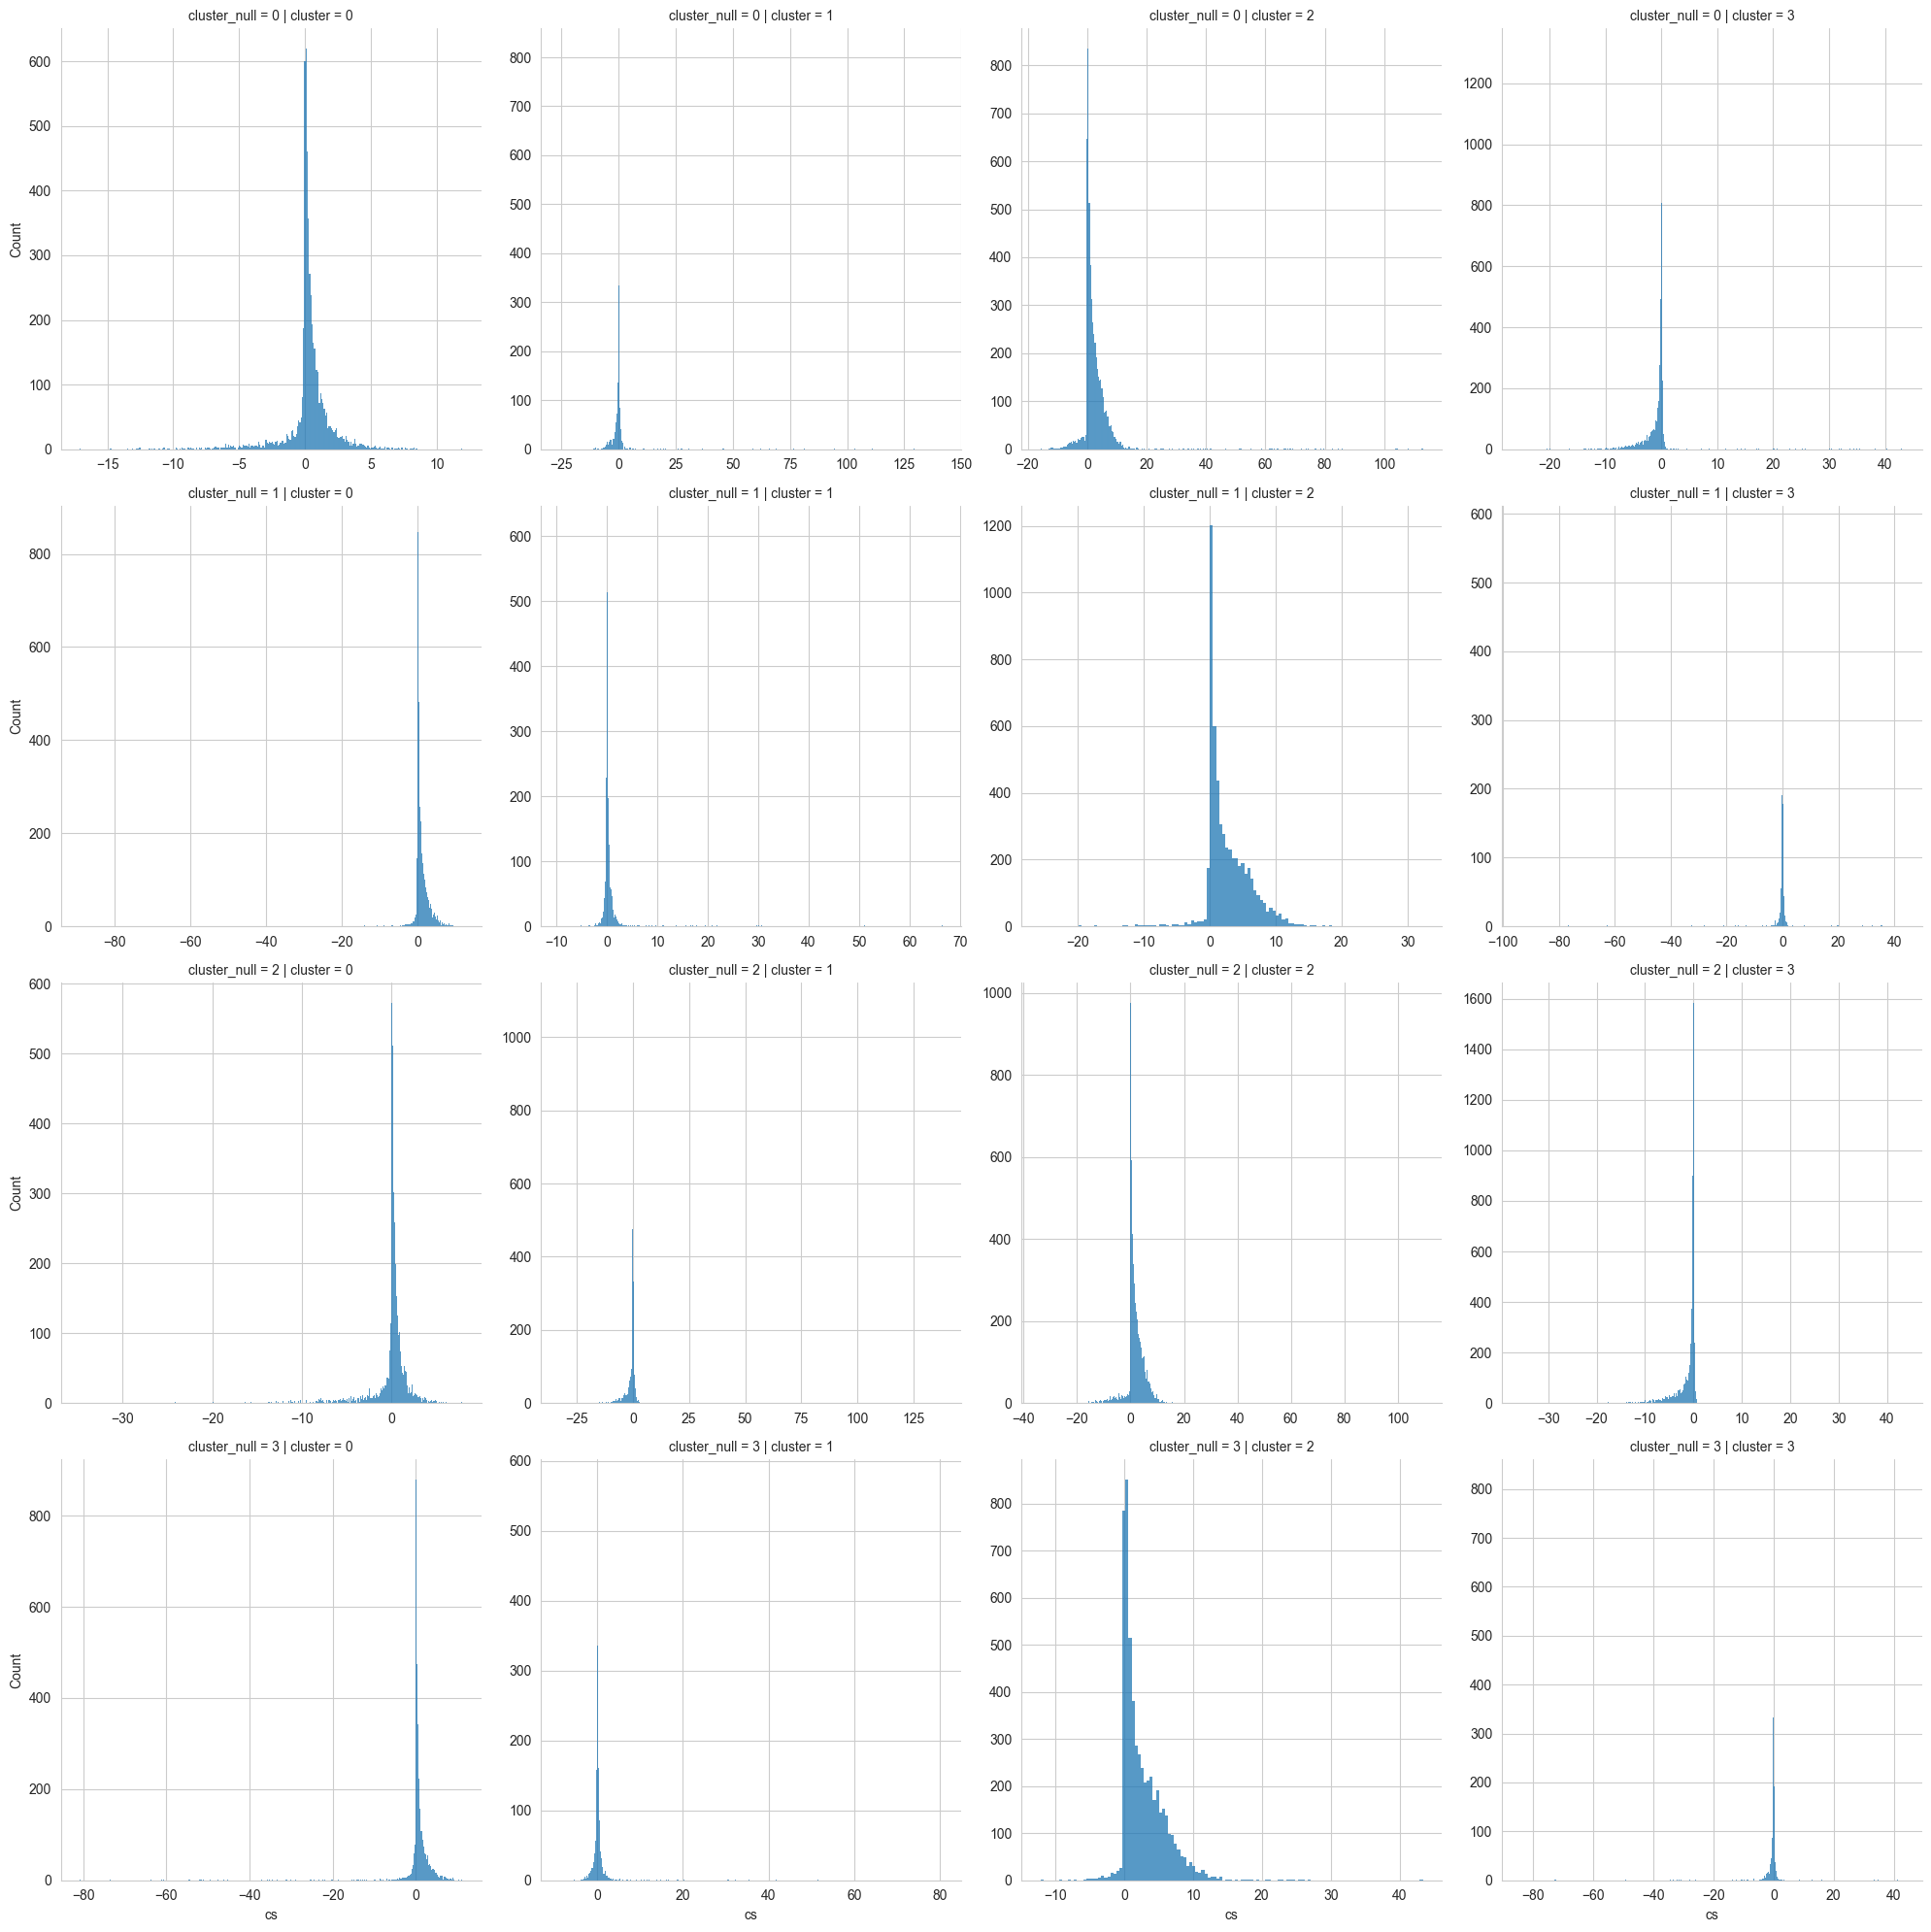

In [130]:
sns.displot(all_pvals_log, row="cluster_null", col="cluster", x="cs", kind="hist", common_bins=False, facet_kws=dict(sharex=False, sharey=False))
# plt.ylim((0,200))
plt.show()

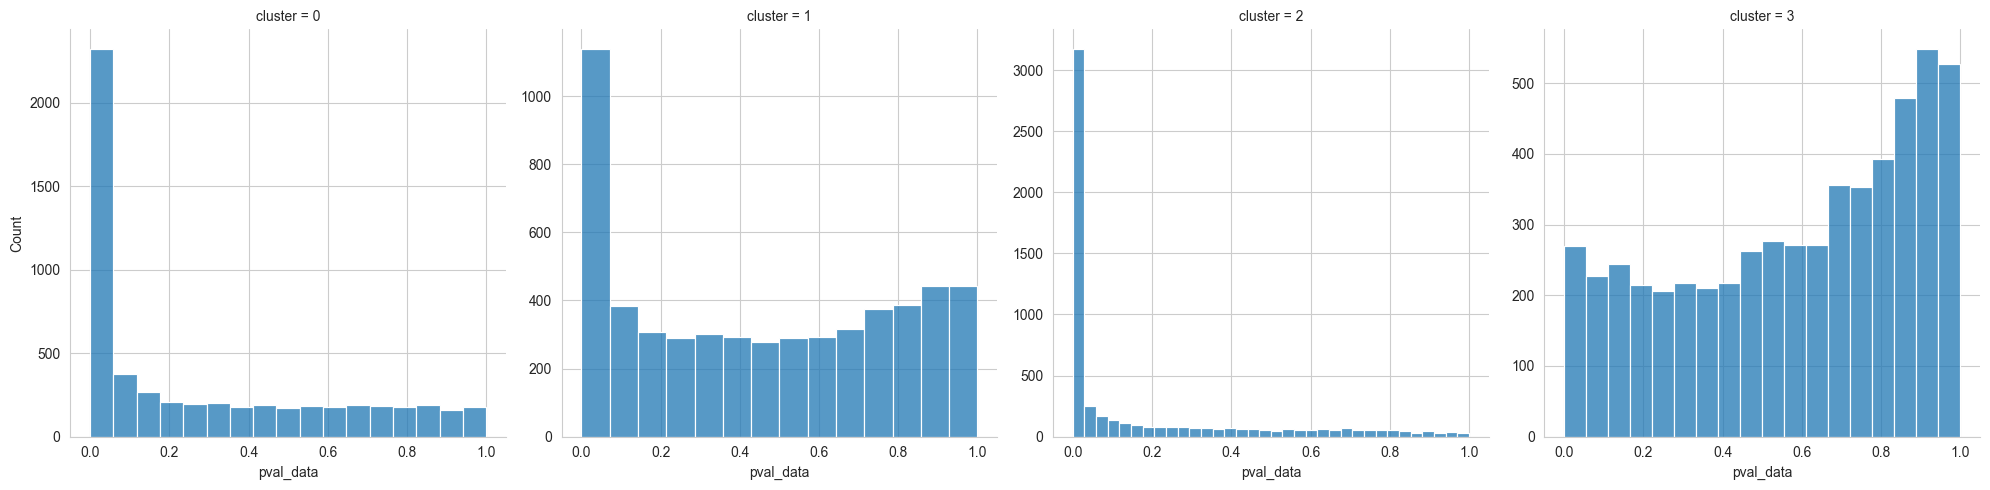

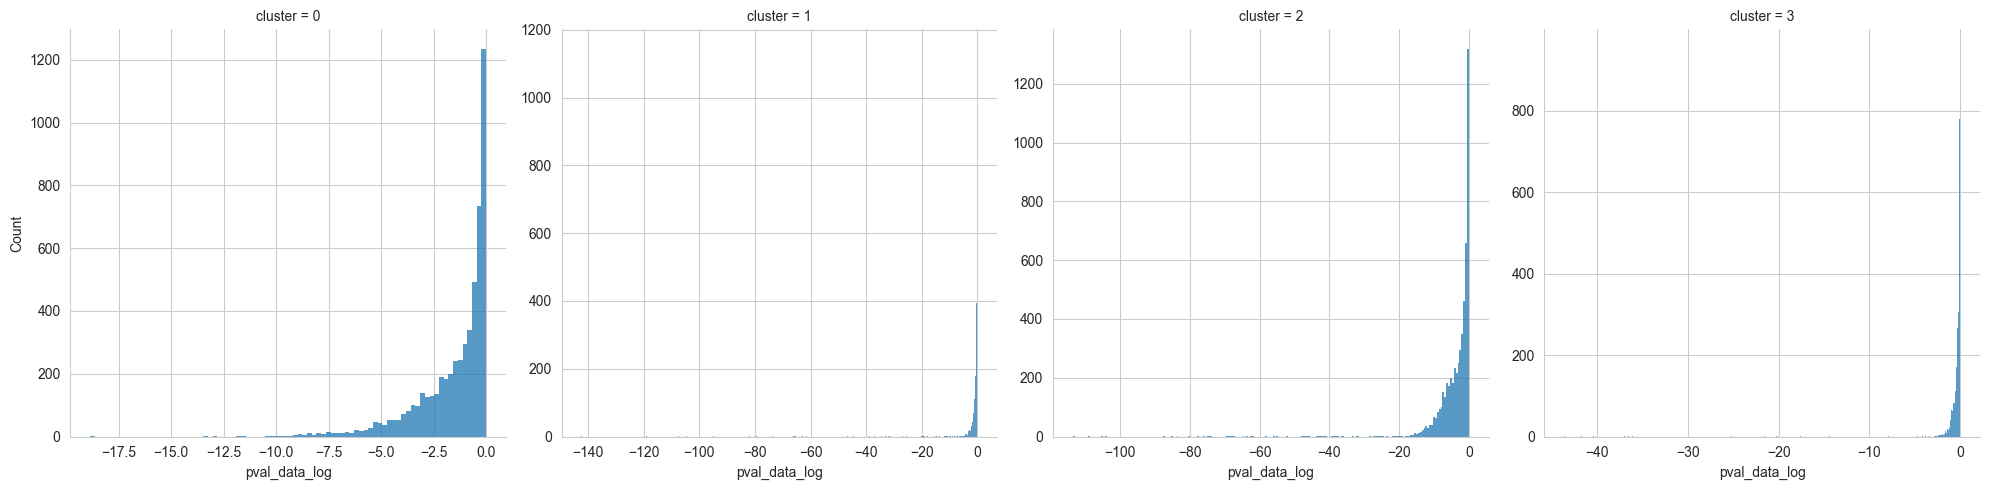

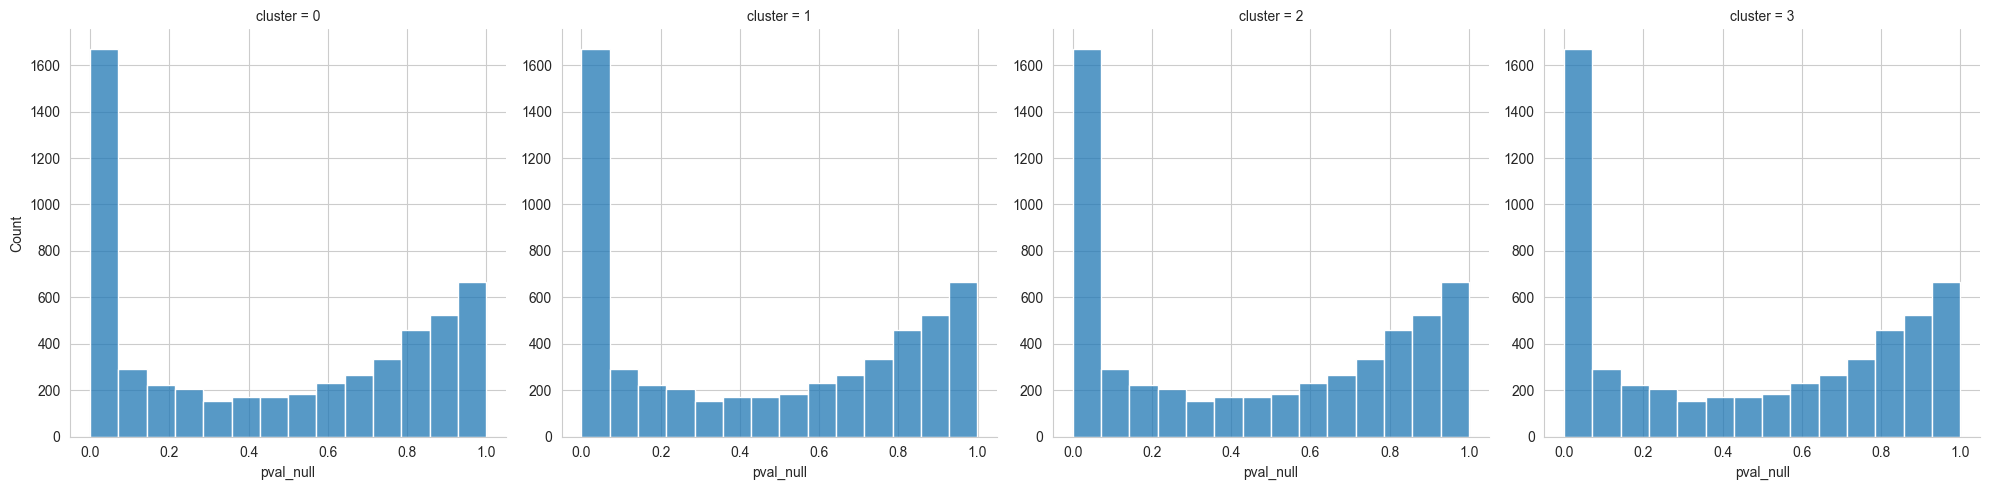

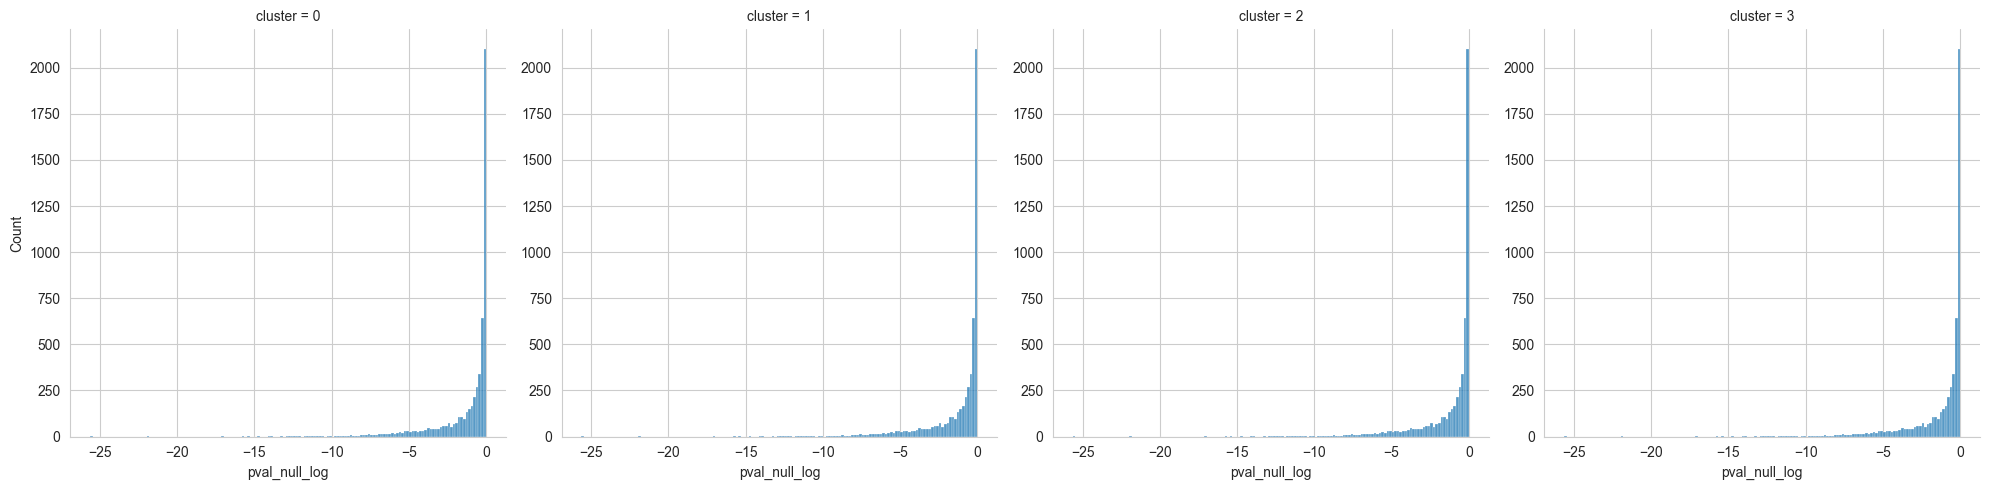

In [143]:
all_pvals_log["pval_data_log"] = np.log10(all_pvals_log["pval_data"])
all_pvals_log["pval_null_log"] = np.log10(all_pvals_log["pval_null"])

sns.displot(all_pvals_log[all_pvals_log["cluster_null"] == "0"], col="cluster", x="pval_data", kind="hist", common_bins=False, facet_kws=dict(sharex=False, sharey=False))
# plt.ylim((0,200))
plt.show()

sns.displot(all_pvals_log[all_pvals_log["cluster_null"] == "0"], col="cluster", x="pval_data_log", kind="hist", common_bins=False, facet_kws=dict(sharex=False, sharey=False))
# plt.ylim((0,200))
plt.show()

sns.displot(all_pvals_log[all_pvals_log["cluster_null"] == "0"], col="cluster", x="pval_null", kind="hist", common_bins=False, facet_kws=dict(sharex=False, sharey=False))
# plt.ylim((0,200))
plt.show()

sns.displot(all_pvals_log[all_pvals_log["cluster_null"] == "0"], col="cluster", x="pval_null_log", kind="hist", common_bins=False, facet_kws=dict(sharex=False, sharey=False))
# plt.ylim((0,200))
plt.show()

In [135]:
for c0 in null_clust:
    print(f"null cluster {c0}")
    for c in clusters:
        print(f"cluster {c}")
        print(pvals_log_gen[(c0, c)]["q"].value_counts().sort_index())
        print("")

null cluster 0
cluster 0
q
0.257030    3556
0.257167       2
0.257303       2
0.257431       6
0.257495       3
            ... 
0.308785       3
0.309130       5
0.309293       1
0.310345       5
1.000000    1313
Name: count, Length: 174, dtype: int64

cluster 1
q
0.015152      66
0.021978      25
0.032609       1
0.075269       1
0.127660       1
0.157895       1
0.187500       1
0.232323       3
0.260000       1
0.303922       2
0.317308       2
0.342857       1
0.367925       1
0.373832       1
0.444444       1
0.509091       2
0.621622       1
0.628319       2
0.824561       1
0.826087       1
0.827586       1
0.897735    2798
0.898050       9
1.000000    2624
Name: count, dtype: int64

cluster 2
q
0.013889     72
0.021277     22
0.031250      2
0.050505      3
0.060000      1
           ... 
0.095692      2
0.095757      7
0.095888     14
0.096245      2
1.000000    487
Name: count, Length: 85, dtype: int64

cluster 3
q
0.047619      21
0.083333       3
0.115385       2
0.137931 

In [138]:
pvals_log_gen[("1", "2")]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q,cluster_null,cluster
PAO1_ID,,,,,,,,
PA4264,3.063816e-114,6.634775e-82,113.513737,81.178174,32.335563,0.041843,1,2
PA4238,1.556333e-62,4.652603e-36,61.807897,35.332304,26.475593,0.041843,1,2
PA4256,1.839384e-109,2.410587e-85,108.735328,84.617877,24.117450,0.041843,1,2
PA4276,3.853479e-38,4.178347e-19,37.414147,18.378996,19.035151,0.041843,1,2
PA0550,1.077227e-27,3.200466e-09,26.967693,8.494787,18.472906,0.041843,1,2
...,...,...,...,...,...,...,...,...
PA4261,1.838861e-65,2.323787e-84,64.735451,83.633804,-18.898353,1.000000,1,2
PA4385,7.913175e-43,2.316193e-62,42.101649,61.635225,-19.533576,1.000000,1,2
PA4245,2.280787e-09,5.760645e-29,8.641915,28.239529,-19.597614,1.000000,1,2


In [30]:
for c in clusters:
    print(c)
    print(len(pvals_log_gen[c][pvals_log_gen[c]["q"] < 0.15]))
    print("")

0
0

1
94

2
5055

3
0


In [31]:
pvals_log_gen["2"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA4256,1.839384e-109,9.483385e-46,108.735328,45.023037,63.712291,0.017857
PA4260,5.837065e-105,3.705470e-47,104.233805,46.431157,57.802649,0.017857
PA4262,7.009442e-106,8.965737e-51,105.154317,50.047414,55.106903,0.017857
PA4264,3.063816e-114,8.151087e-60,113.513737,59.088784,54.424953,0.017857
PA5559,3.960962e-81,1.538122e-28,80.402199,27.813009,52.589190,0.017857
...,...,...,...,...,...,...
PA1198,3.861857e-02,1.522344e-16,1.413204,15.817487,-14.404283,1.000000
PA5049,3.692323e-02,5.631550e-17,1.432700,16.249372,-14.816672,1.000000
PA3194,6.668307e-02,2.379890e-19,1.175984,18.623443,-17.447459,1.000000


['PA4264', 'PA4260', 'PA4262', 'PA4256', 'PA4251', 'PA4267', 'PA4252', 'PA4274', 'PA4250', 'PA5556']


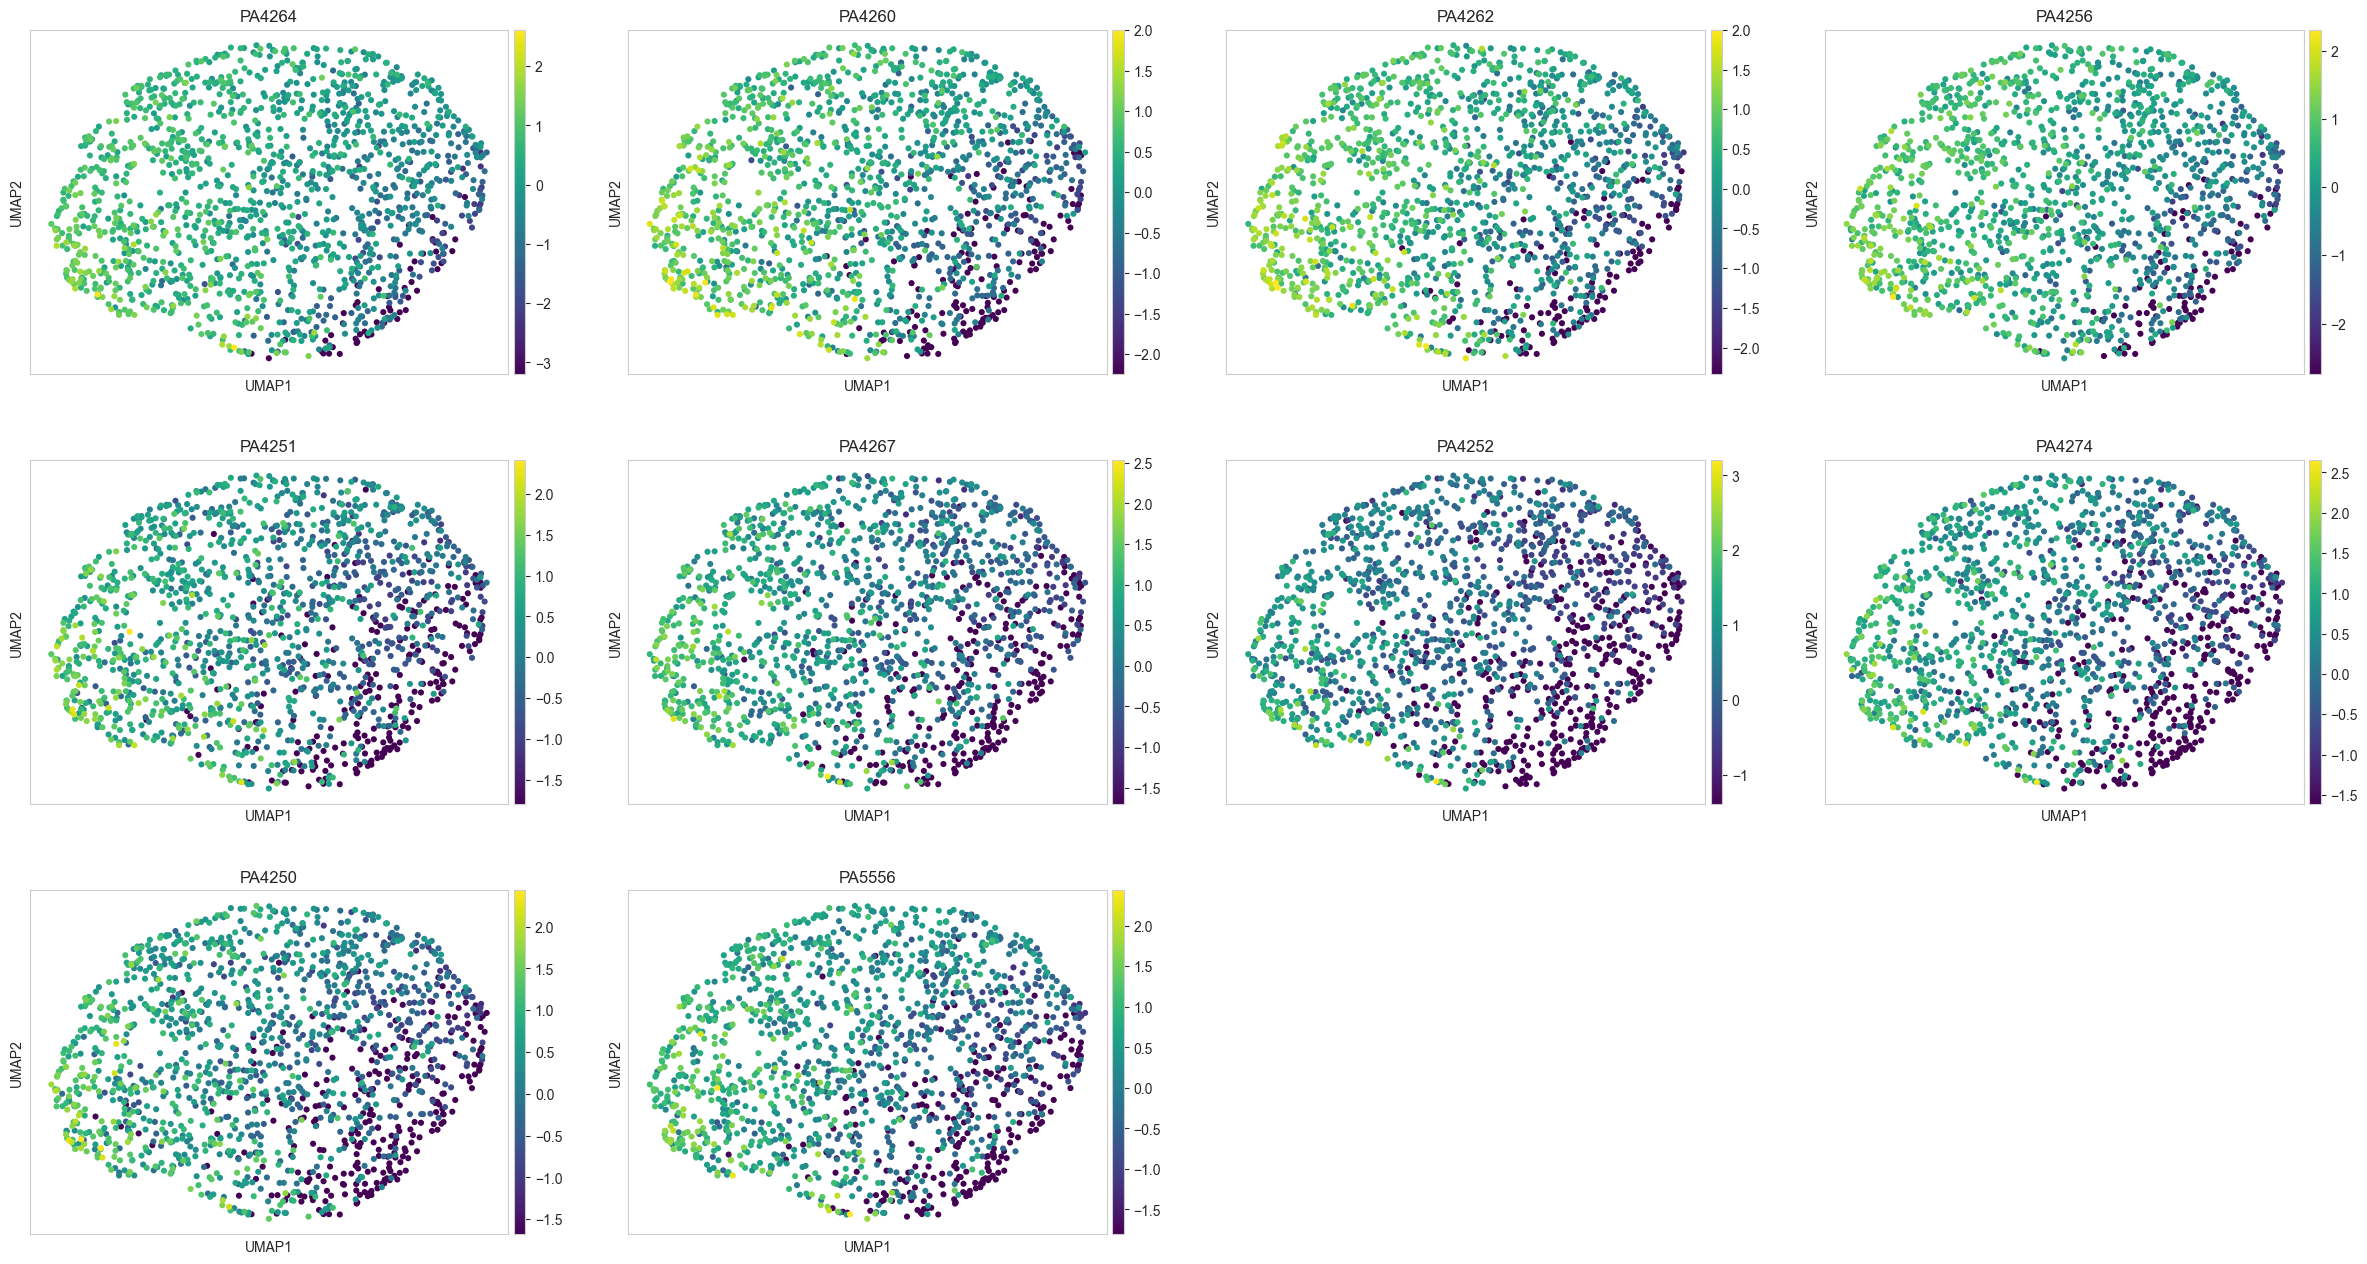

In [78]:
# goi = pvals_log_gen["3"].sort_values("pval_null", ascending=True).index[:10]
goi = ['PA4264', 'PA4260', 'PA4262', 'PA4256', 'PA4251', 'PA4267', 'PA4252',
       'PA4274', 'PA4250', 'PA5556']
print(goi)

sc.pl.umap(data_null_gen, color=goi, cmap="viridis")